# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

/home/stroykova/.local/lib/python2.7/site-packages/sklearn/utils/sparsetools/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._min_spanning_tree import minimum_spanning_tree
/home/stroykova/.local/lib/python2.7/site-packages/sklearn/utils/sparsetools/_graph_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._graph_tools import csgraph_to_dense, csgraph_from_dense,\
/home/stroykova/.local/lib/python2.7/site-packages/sklearn/utils/sparsetools/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._traversal import connected_components
/usr/lib/python2.7/dist-packages/scipy/spatial/__init__.py:90: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .ckdtree import *
/usr/lib/python2.7/dist-packages/scipy/spatial/__init__.py:91: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  fr

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:252: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._rank import rankdata, tiecorrect
/home/stroykova/.local/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .expected_mutual_info_fast import expected_mutual_information
/home/stroykova/.local/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:56: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan


Зачитываем результат 4 домашки

In [2]:
data = np.load("files/out_4.dat.npz")
users = data["users"]
X = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [53]:
TRAINING_SET_URL = "twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["twitter_id", "is_1", "is_2", "is_3"], dtype={"twitter_id": str, "is_1": int, 'is_2': int, "is_3": int})
df_users.set_index("twitter_id", inplace=True)
df_users.head()
df_users.shape

(3000, 3)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой. (Этого бы не пришлось делать, если бы мы в 4 домашке сохранили целевую -- надо учесть на будущее).

In [56]:
def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

    
print df_users[['is_1', 'is_2', 'is_3']]
print X.todense()
    
Y = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1)
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

            is_1  is_2  is_3
twitter_id                  
66412773       0     0     1
10143902       0     0     1
73701917       0     0     1
82209363       0     0     1
47063951       0     0     1
135356953      0     0     1
51119725       0     0     1
20161265       0     0     1
20531501       1     0     0
2465042894     1     0     0
126769653      0     0     1
1393430989     1     0     0
2727183168     1     0     0
456714127      0     1     0
712837309      0     1     0
3016396175     0     1     0
962185548      1     0     0
476090138      1     0     0
820359624      1     0     0
119573305      0     0     1
261929028      1     0     0
1618356541     1     0     0
484495548      0     1     0
130406943      0     0     1
357859404      1     0     0
111898474      0     0     1
526665169      0     0     1
1662361148     0     0     1
370845108      0     1     0
384011936      1     0     0
...          ...   ...   ...
52102999       0     0     1
180856318     

Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа.

[     0     21     26 ..., 838524 838525 838526]
[21  5  1 ...,  2  1  1]
70832
70832
[    0 42339  7844 ...,     0     0     1]


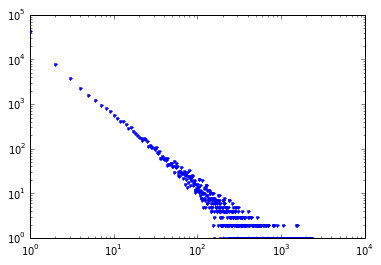

In [33]:
col_counts = np.diff(X.tocsc().indptr)
print X.tocsc().indptr
print col_counts
print len(col_counts)
print X.shape[1]
bin_counts = np.bincount(col_counts)
print bin_counts
pl.plot(np.arange(bin_counts.shape[0]), bin_counts, ".")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [34]:
X1 = X.tocsc()[:, col_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [35]:
USER_NAME = "n.anokhin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [65]:
class LogisticRegression():
    
    def fit(self, X, Y=None):
        return self
    
    def predict_proba(self, X):
        import numpy.random as nr
        p = nr.random((X.shape[0], 3))
        return p / p.sum(axis=1)[:, np.newaxis]

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [66]:
def auroc(y_prob, y_true):
    return 0.5

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [67]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
skf = cv.StratifiedKFold(Y, len(C))
for i, (train, test) in enumerate(skf):
    X_train, Y_train = X1[train], Y[train]
    X_test, Y_test = X1[test], Y[test]
    model = LogisticRegression().fit(X_train, Y_train)
    print i, auroc(model.predict_proba(X_test)[:, 0], Y_test)

0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

[1 2 1 3 3 1 3 1 3 1 3 3 3 3 3 2 1 3 1 1 1 1 1 3 3 1 2 2 1 2 2 2 1 3 3 1 1
 3 1 1 2 3 3 1 1 1 1 2 1 2 1 1 1 2 1 1 3 2 1 3 1 3 3 2 3 3 1 3 1 3 3 2 2 3
 1 1 2 2 1 1 1 2 3 1 1 2 3 3 3 3 1 3 3 1 3 1 1 1 2 2 1 1 3 2 3 1 3 1 2 3 3
 3 1 1 1 1 2 2 3 1 1 2 1 3 3 3 1 3 1 1 3 3 1 3 3 1 1 3 3 1 3 1 1 1 3 1 1 3
 1 1 1 3 1 3 3 1 2 1 1 3 3 3 3 1 1 1 3 1 3 1 1 3 1 1 3 1 1 3 1 2 3 2 2 3 3
 2 1 3 1 2 1 3 3 2 1 2 3 1 1 1 3 1 2 3 2 1 2 3 1 1 2 2 3 3 3 3 3 1 1 2 1 3
 2 1 1 3 1 3 3 2 3 3 3 1 3 1 2 3 1 3 3 1 1 3 2 3 1 3 3 1 1 1 1 1 3 2 1 3 3
 3 3 1 3 3 3 1 3 2 3 1 3 1 3 1 1 1 1 3 2 2 3 3 3 3 3 3 3 3 2 3 3 1 2 3 1 2
 3 2 3 2 3 1 1 1 3 3 3 3 2 1 1 2 3 3 1 3 1 3 1 1 1 1 1 3 3 3 1 3 2 3 3 3 3
 1 3 1 1 2 2 1 3 1 2 3 3 3 1 1 1 1 1 2 3 3 1 2 2 2 3 3 2 1 3 3 1 2 3 2 3 1
 1 1 3 1 2 1 3 3 3 3 1 1 2 1 3 1 1 1 1 2 3 2 1 2 1 3 1 1 1 1 1 1 2 1 1 1 3
 2 3 3 3 1 3 1 1 1 3 3 3 3 3 1 3 2 1 1 3 3 2 1 3 2 1 1 3 1 1 1 1 1 1 3 1 3
 3 1 1 1 1 2 1 1 3 3 1 1 3 3 3 2 2 1 1 3 1 1 3 1 1 3 2 3 2 1 1 3 2 3 3 1 2
 2 1 3 1 3 3 1 3 2 1 1 2 

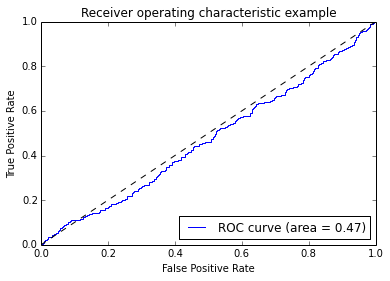

In [72]:

X_train, X_test, Y_train, Y_test = cv.train_test_split(X1[1:], Y, test_size=0.3)
Y_prob = LogisticRegression().fit(X_train, Y_train).predict_proba(X_test)

print Y_test, Y_prob
print Y_test.shape, Y_prob.shape


fpr, tpr, thresholds = sm.roc_curve(Y_test, Y_prob[:, 0], pos_label=1)
roc_auc = sm.auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате.